# Intro  

In this notebook I demonstrate using my implementation of (planar) normalizing flows on a density esitimation task.  

Here is another tutorial on using normalizing flows with the pymc library https://docs.pymc.io/notebooks/normalizing_flows_overview.html

In [28]:
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
import scipy as sp
from scipy.stats import multivariate_normal
from time import time

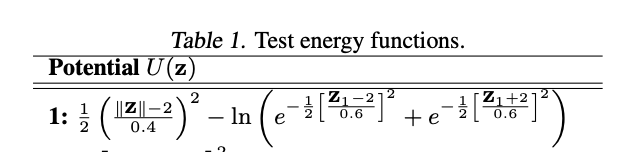  
In this task we try to model an unnormalized probablitly distribution of the form exp(-U) with normalizing flows.  

Image from https://arxiv.org/pdf/1505.05770.pdf (page 7)

In [2]:
## Test function 
def test_fn(z):
    t1 = 0.5 * ((tf.norm(z, axis=1) - 2.0)/0.4) ** 2 
    
    exp1 = -0.5* ((z[:, 0] - 2.0)/0.6)**2   
    exp2 = -0.5* ((z[:, 0] + 2.0)/0.6)**2   
    
    t2 = tf.math.log(tf.exp(exp1) + tf.exp(exp2))
    return t1 - t2

# unnormalized test distribution
def un_test_distr(z): 
    return tf.exp(-test_fn(z))

### Visualize the test function

In [3]:
xmin, xmax = -4, 4
ymin, ymax = -4, 4
mesh_count=1000


x = tf.linspace(xmin, xmax, mesh_count)
y = tf.linspace(ymin, ymax, mesh_count)
X, Y = tf.meshgrid(x, y)

concatenated_mesh_coordinates = tf.transpose(tf.stack([tf.reshape(Y, [-1]), tf.reshape(X, [-1])]))
concatenated_mesh_coordinates

<tf.Tensor: shape=(1000000, 2), dtype=float64, numpy=
array([[-4.        , -4.        ],
       [-4.        , -3.99199199],
       [-4.        , -3.98398398],
       ...,
       [ 4.        ,  3.98398398],
       [ 4.        ,  3.99199199],
       [ 4.        ,  4.        ]])>

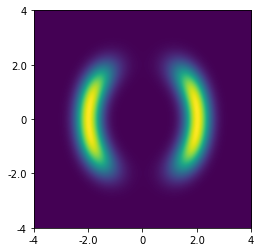

In [4]:
prob = un_test_distr(concatenated_mesh_coordinates)
plt.imshow(tf.transpose(tf.reshape(prob, (mesh_count, mesh_count))), origin="lower")
plt.xticks([0, mesh_count * 0.25, mesh_count * 0.5, mesh_count * 0.75, mesh_count], [xmin, xmin/2, 0, xmax/2, xmax])
plt.yticks([0, mesh_count * 0.25, mesh_count * 0.5, mesh_count * 0.75, mesh_count], [ymin, ymin/2, 0, ymax/2, ymax])
# plt.title("Target Density")
plt.show()

In [5]:
[0, mesh_count * 0.25, mesh_count * 0.5, mesh_count * 0.75, mesh_count]

[0, 250.0, 500.0, 750.0, 1000]

In [6]:
[mesh_count * 0.125*i for i in range(8)]

[0.0, 125.0, 250.0, 375.0, 500.0, 625.0, 750.0, 875.0]

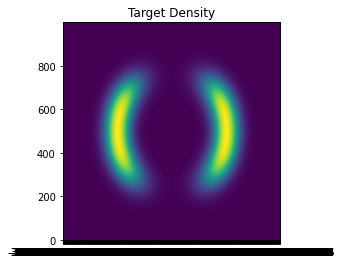

In [7]:
prob = un_test_distr(concatenated_mesh_coordinates)
plt.imshow(tf.transpose(tf.reshape(prob, (mesh_count, mesh_count))), origin="lower")
plt.xticks(range(mesh_count), x.numpy())
plt.xticks(range(mesh_count), x.numpy())
# plt.xticks([0, mesh_count * 0.25, mesh_count * 0.5, mesh_count * 0.75, mesh_count], [xmin, xmin/2, 0, xmax/2, xmax])
# plt.yticks([0, mesh_count * 0.25, mesh_count * 0.5, mesh_count * 0.75, mesh_count], [ymin, ymin/2, 0, ymax/2, ymax])
plt.title("Target Density")
plt.show()

### Normalizing flows

In [8]:
import tensorflow_probability as tfp

In [9]:
class PlanarFlow(tf.keras.layers.Layer):
    def __init__(self, input_dimensions):
        """
        :param input_dimensions: int: The dimesionality of the randon variable (z)
        """
        super().__init__()
        
        self.u = tf.Variable(np.random.uniform(-2., 2., size=(input_dimensions)), 
                             name='u', dtype=tf.float32, trainable=True)
        
        self.w = tf.Variable(np.random.uniform(-2., 2., size=(input_dimensions)), 
                             name='w', dtype=tf.float32, trainable=True)
        
        self.b = tf.Variable(np.random.uniform(-2., 2., size=(1)), 
                             name='b', dtype=tf.float32, trainable=True)

        
    def call(self, z_prev):
        

        u_hat = self.uhat()  # uhat, ensures invertable

        z_prev = tf.transpose(z_prev)
        inner = tf.add(tf.tensordot(self.w, z_prev, axes=1), self.b)
        to_add = tf.tensordot(u_hat, self.h(inner), axes=0)
        z_next = tf.add(z_prev, to_add)
        return tf.transpose(z_next)
    
    
    def uhat(self):
        wu = tf.multiply( self.w, self.u)
        m = -1.0 + tf.nn.softplus(wu)
        alpha = tf.subtract(m, wu)

        z_para =tf.transpose( alpha * tf.transpose(self.w) / tf.math.sqrt(tf.reduce_sum(self.w ** 2.0)))

        u_hat = tf.add(self.u, z_para)
        return u_hat


    def inv_call(self, 
                 z_next, 
                 init=0.0, 
                 max_iter = 10000, 
                 tol=1e-12, 
                 update_freq=None, 
                 optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01, momentum=0.6),
                 return_iter = False):
        """
        :param z_next: vector: Input vector to invert the flow on 
        :param init: float: Initial guess at alpha parameter
        :param max_iter: int: Number of iterations to perform when solving for alpha
        :param tol: float: How close computed alpha must be to true value. Higher values are faster, but less accurate
        :param update_freq: int: How often to print updates when solving for alpha
        :param optimizer: optimizer: Used to compute alpha
        :param return_iter: bool: Return the number of iterations need to converge computing alpha
        """
        
        
        alpha = self._compute_alpha(z_next, init, max_iter, tol, update_freq, optimizer, return_iter)
        if return_iter:
            alpha, i = alpha
        
        z_par =  alpha * self.w / tf.reduce_sum(tf.square(self.w))
        inner = tf.add(tf.tensordot(self.w, z_par, axes=1), self.b)
        to_subt = tf.tensordot(self.uhat(), self.h(inner), axes=0)
        z_prev = z_next  - to_subt

        if return_iter:
            return z_prev, i
        else:
            return z_prev
        
    
    def det_jcb(self, z):
        # determinitate of the jacobian at z
        z = tf.transpose(z)
        psi = self.psi(z)
        inner = tf.add(1.0, tf.tensordot(self.uhat(), psi, axes=1))
        return tf.abs(inner)
    
    
    def psi(self, z):
        # intermidiate value for computing det_jcb
        inner = tf.add(tf.tensordot(self.w, z, axes=1), self.b)
        psi_z = tf.tensordot(self.w, self.h_prime(inner), axes=0)
        return psi_z
    
    def h(self, y):
        # the non linearity in the flow
        return tf.math.tanh(y)
    

    def h_prime(self, y):
        # derivative of h
        return 1.0 - tf.math.tanh(y) ** 2.0
    
    
    def m(self, x):
        # intermidiate value in other functions
        return -1.0 + tf.nn.softplus(x)

    
    # see inv_call for meaning of args
    def _compute_alpha(self, fz, 
                      init, max_iter, tol, 
                      update_freq, optimizer,
                     return_iter):
         
        
        alpha = tf.Variable(init)
        
        converged=False
        for i in range(max_iter):
            
            with tf.GradientTape() as tape:
                wTu = tf.tensordot(self.w, self.uhat(), axes=1)
                wTfz= tf.tensordot(self.w, fz, axes=1)

                diff = alpha + wTu*self.h(alpha + self.b) - wTfz
                loss = diff **2
                
            variables = [alpha]
            gradients = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(gradients, variables))


            if update_freq:
                if i % update_freq == 1:
                    print("after", i, "iters, alpha=", alpha, ", loss=", loss)


            if tf.reduce_max(loss) < tol:
                converged = True
                if update_freq:
                    print("Converged after", i, "iters")
                break
                
        if converged:
            if return_iter:
                return alpha, i
            else:
                return alpha
        else:
            print("Failed to converge")
            print("after", i, "iters, alpha=", alpha, ", loss=", loss)
            raise Exception("Did not converge!")    
    
    
            
class FlowSequnce:

    def __init__(self, 
                 flow_len, 
                 flow_dim, 
                 q0 = tfp.distributions.Normal(loc=0.0, scale=1.0), 
                 flow_type= PlanarFlow,
                 optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5, momentum=0.9)
                ):
        """
        :param flow_len: int: The number of individual flow transformations
        :param flow_dim: int: The dimesionality of the randon variable (z)
        :param q0: a tfp.distribution: Base distribution for the flow
        :param flow_type: Type of flow. Only planar implemented. 
        """
     

        self.k = flow_len
        self.dim = flow_dim
        self.q0 = q0
        self.flow_type = flow_type  
        self.flows = []
        self.optimizer = optimizer
        
        
        for _ in range(flow_len):
            self.flows.append(flow_type(flow_dim))
            
            
        self.trainable_variables = []
        for flow in self.flows:
            self.trainable_variables += flow.trainable_variables
            
        
    def forward_pass(self, samples):
        """
        Given samples from the base distribution, compute forward pass through all flow 
        layers, computing the sum of log_det of the jacobian along the way.
        
        :param flow_len: int: The number of individual flow transformations
        :param flow_dim: int: The dimesionality of the randon variable (z)
        :param q0: a tfp.distribution: Base distribution for the flow
        :param flow_type: Type of flow. Only planar implemented. 
        
        :return transformed sample and sum of log detss
        """            
        z_i = samples 
        log_det = 0.0
        
        for i, flow_layer in enumerate(self.flows):
            
            log_det += tf.math.log(flow_layer.det_jcb(z_i))
            z_i = flow_layer(z_i)
             
        return z_i, log_det
    
    
    def sample_base(self, n_samples):
        # draw samples from the base distribution 
        return self.q0.sample((n_samples, self.dim))
    
    
    def sample_final(self, n_samples):      
        # draw random samples from the final distribution
        return self.forward_pass(self.sample_base(n_samples))[0]
    
    
    @tf.function
    def train_step(self, batch_size):
        with tf.GradientTape() as tape:

            z_0 = self.sample_base(batch_size) # draw random sample from base distribution
            z_t, log_det = self.forward_pass(z_0) # feed the sample through flows, computing log dets


            l0 = tf.reduce_sum(tf.math.log(normal_distr.prob(z_0)), axis=1) # log prob of intial sample under normal distr

            l1 = -log_det  # minus the sum of log detertiminants of the transformation 
            l2 = test_fn(z_t) # minus the log of the unnormalized probability of z_t under test distr

            loss = tf.reduce_mean(l0 + l1 + l2) 

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return loss, l0, l1, l2
    

In [10]:
def invert_flow_seq(flow_seq, z_final):
    z_i = z_final
    for j, flow_layer in enumerate(reversed(flow_seq.flows)):
        print("inverting", len(flow_seq.flows)-j)
        z_i = flow_layer.inv_call(z_i, max_iter=100_000 )
    return z_i

### Settings for training the flows

In [14]:
reps = 1
flow_lens = [2, 8, 16, 32]
epochs = 500_000
batch_size = 100 
print_every = 100_000
batch_size = 100
samples_in_plots = 2000
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5, momentum=0.9)

In [15]:
flow_models = []

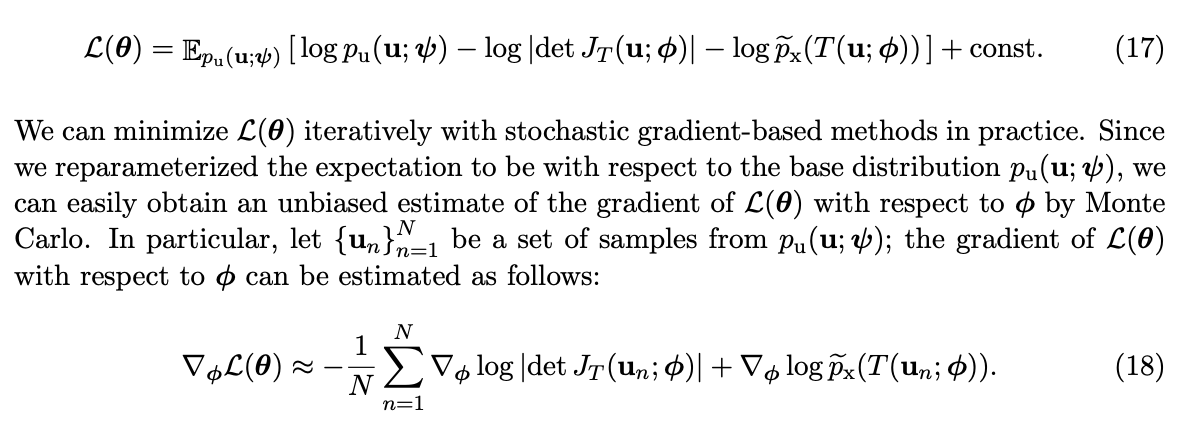  
Image from: https://arxiv.org/pdf/1912.02762.pdf (page 7)

### Fit the flow model

In [27]:
from scipy.stats import kde

def show_update(flow_seq, 
                n_samples, 
                plot=True,
                print_bal = True):

    
    z_ = flow_seq.sample_final(samples_in_plots)
    
    if plot:
        plt.scatter(z_[:, 0], z_[:, 1], alpha=0.1)
        plt.xlim([-4,4])
        plt.ylim([-4,4])
        plt.show()
    
    if print_bal:
        gt = tf.reduce_sum(tf.cast(z_[:, 0]>0, tf.float32)).numpy()
        lt = tf.reduce_sum(tf.cast(z_[:, 0]<0, tf.float32)).numpy()
        print("lt , gt:", lt, gt)


def plot_estimated_density(model, 
                          samples=10_000,
                          nbins=50):
    
    data = flow_seq.sample_final(10000).numpy()
    x,y = data.T
    
    k = kde.gaussian_kde(data.T)
    xi, yi = np.mgrid[-4.:4.:nbins*1j, -4.:4.:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud')
    plt.xlim([-4,4])
    plt.ylim([-4,4])
    plt.show()
    

Begin rep 0 with len = 2 	ID is 2_0
loss after 99999 is: -1.0480468


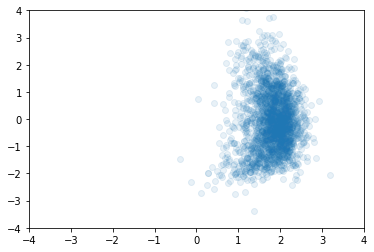

lt , gt: 2.0 1998.0
loss after 199999 is: -1.1285377


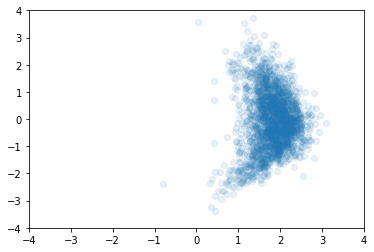

lt , gt: 1.0 1999.0
loss after 299999 is: -1.0969918


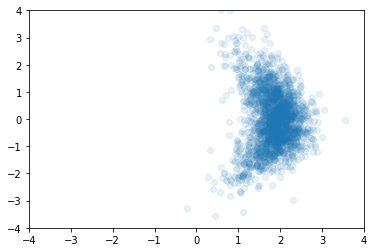

lt , gt: 1.0 1999.0
loss after 399999 is: -1.1686261


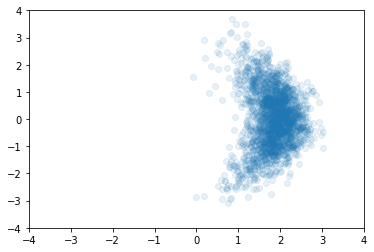

lt , gt: 1.0 1999.0
loss after 499999 is: -1.1118941


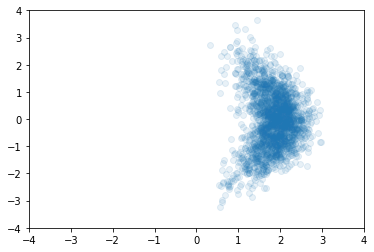

lt , gt: 0.0 2000.0











Begin rep 0 with len = 8 	ID is 8_0
loss after 99999 is: -1.7800919


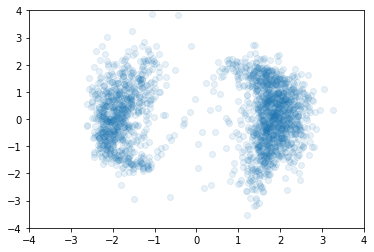

lt , gt: 787.0 1213.0
loss after 199999 is: -1.8119015


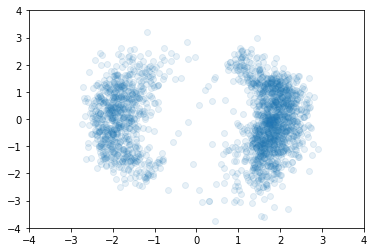

lt , gt: 753.0 1247.0
loss after 299999 is: -1.7883083


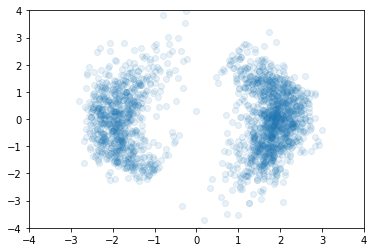

lt , gt: 791.0 1209.0
loss after 399999 is: -1.789601


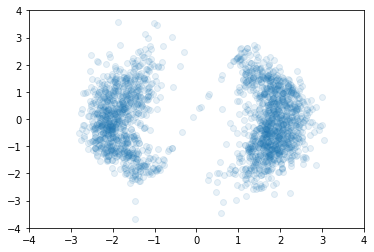

lt , gt: 892.0 1108.0
loss after 499999 is: -1.8096187


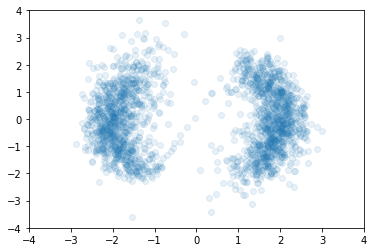

lt , gt: 951.0 1049.0











Begin rep 0 with len = 16 	ID is 16_0
loss after 99999 is: -2.4567554


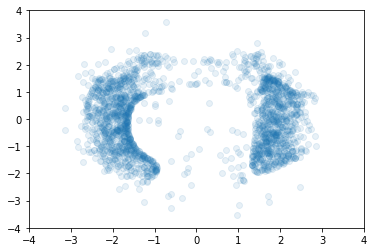

lt , gt: 1074.0 926.0
Nan loss :(











Begin rep 0 with len = 32 	ID is 32_0
Nan loss :(













In [17]:
normal_distr =  tfp.distributions.Normal(loc=0.0, scale=1.0) #multivariate_normal(mean= np.zeros(2), cov=np.identity(2))
debugging = []

for rep_i in range(reps):
    for flow_len in flow_lens:
        nan_loss = False
        id_str = "{}_{}".format(flow_len, rep_i)
        print("Begin rep", rep_i, "with len =", flow_len, "\tID is", id_str)
        
        flow_seq = FlowSequnce(flow_len=flow_len, flow_dim=2, optimizer=optimizer)
        flow_seq.id = id_str
        

        for i in range(epochs):

            loss, *other = flow_seq.train_step(batch_size) 

            ###   Info update      ###
            if i % print_every == print_every-1:
                print("loss after", i, "is:", loss.numpy())
                show_update(flow_seq, samples_in_plots)
                
                
            if tf.math.is_nan(loss):
                debugging.append((prev_other, other))
                nan_loss = True
                print("Nan loss :(")
                break
            prev_other = other # for debugging nans

        if not nan_loss:
            flow_models.append(flow_seq)
            
        print("\n"*10)

### Examine models after fitting

8_0
loss is: -1.8338273


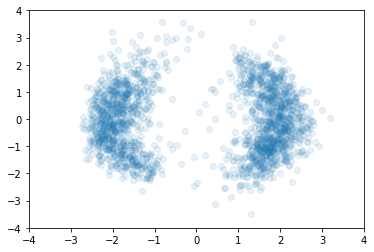

lt , gt: 923.0 1077.0
tf.Tensor(154.0, shape=(), dtype=float32)






In [20]:
### Throw out unbalanced distirubutions 

def balance_score(flow_seq, samples_in_plots):
    z_ = flow_seq.sample_final(samples_in_plots)
    
    gt = tf.reduce_sum(tf.cast(z_[:, 0]>0, tf.float32)).numpy()
    lt = tf.reduce_sum(tf.cast(z_[:, 0]<0, tf.float32)).numpy()
    return tf.abs(gt-lt)


good_seqs = list(filter(lambda x: balance_score(x,samples_in_plots) < samples_in_plots/4., flow_models))
for flow_seq in good_seqs:
    
    loss, *other = flow_seq.train_step(batch_size) 

    print(flow_seq.id)
    
    print("loss is:", loss.numpy())
    show_update(flow_seq, samples_in_plots)
    print(balance_score(flow_seq, samples_in_plots))
    print("\n"*3)

#### Show best of each lenght

In [21]:
seqs_by_fl = dict([(fl, []) for fl in flow_lens])

for flow_seq in good_seqs:
    
    loss, *other = flow_seq.train_step(batch_size) 

    fl = int(flow_seq.id.split("_")[0])
    seqs_by_fl[fl].append((loss.numpy(), flow_seq))
    


******************** Flow len = 2 ********************





******************** Flow len = 8 ********************
loss is: -1.8487375


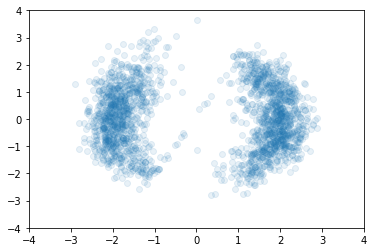

lt , gt: 945.0 1055.0
tf.Tensor(38.0, shape=(), dtype=float32)


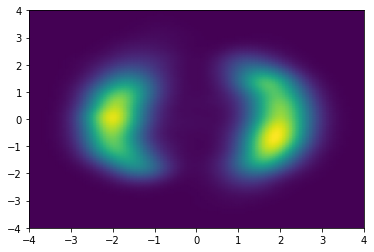










******************** Flow len = 16 ********************





******************** Flow len = 32 ********************







In [26]:
show_per_len = 3
for fl, seqs in seqs_by_fl.items():
    print("*"*20,"Flow len =", fl, "*"*20)
    
    
    show = min(len(seqs), show_per_len)
    for loss, flow_seq in sorted(seqs, key=lambda x: x[0])[:show]:
    
        print("loss is:", loss)
        
        show_update(flow_seq, samples_in_plots)
        print(balance_score(flow_seq, samples_in_plots))
        plot_estimated_density(flow_seq, samples=20_000, nbins=100)
        print("\n"*3)
        
    print("\n"*4)